Make sure to install the imported packages (sklearn, pandas, tensorflow, numpy, matplotlib) and put the dataset inside a folder data, in the same directory as the notebook


Importing the necessary python packages

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

We will now read our dataset and combine the different tables into one dataframe (per type)

In [ ]:
cars = pd.read_csv("data/car_0.csv") # Charger le jeu de données


likes_list = [pd.read_csv("data/like_0.csv"), pd.read_csv("data/like_2.csv"), pd.read_csv("data/like_3.csv"), pd.read_csv("data/like_4.csv"),]
users_list = [pd.read_csv("data/user_0.csv"), pd.read_csv("data/user_2.csv"), pd.read_csv("data/user_3.csv"), pd.read_csv("data/user_4.csv"),]





like = pd.concat(likes_list, axis=0, ignore_index=True)
user = pd.concat(users_list, axis=0, ignore_index=True)

## Idea

Combining session based (sequential recommendations) with car data (representation)
We represent the cars as a vector of size 32
the user's ideal car (propagating vector in the RNN) is set to the users demands initially

In [ ]:
cars.head()

,brand,model,dealer,url,price,year,km,fuel,gearbox,color,doors,seats,fiscalPower,DINPower,critAir,nb_img,link,id
0,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2221069564.htm,12890,2017,60933,Essence,Manuelle,Blanc,5,5.0,4,82,1.0,7,NaN,2
1,RENAULT,Talisman,sofibrie,https://www.leboncoin.fr/voitures/2218598351.htm,24900,2019,63510,Essence,Automatique,Gris,5,5.0,8,159,1.0,20,NaN,3
2,RENAULT,Kadjar,sofibrie,https://www.leboncoin.fr/voitures/2229908445.htm,20890,2019,58858,Diesel,Manuelle,Gris,5,5.0,6,116,2.0,20,NaN,4
3,RENAULT,Koleos,sofibrie,https://www.leboncoin.fr/voitures/2301949775.htm,36490,2022,64,Essence,Automatique,Noir,5,5.0,8,158,1.0,20,NaN,5
4,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2274683789.htm,14890,2021,42555,Essence,Manuelle,Gris,5,5.0,4,83,1.0,20,NaN,6


We can assign a weight (number of repetitions) for each parameter/feature of the car. It just has to add up to 32.

In [ ]:
parameter_weights = {"brand":2, "model":2,"price":4, "year": 2, "km": 3, "fuel": 5, "gearbox":4, "color": 3, "doors": 1, "seats": 1, "fiscalPower": 2, "DINPower": 2, "critAir": 1}

In [ ]:
print("This number has to be exactly equal to 32 :")
sum(parameter_weights.values())

This number has to be exactly equal to 32 :


32

In [ ]:
# Transformation des variables catégorielles en nombres
def map_to_num(dataf, colname):
    mapping = {item:i for i, item in enumerate(dataf[colname].unique())}
    dataf[colname+"_n"] = dataf[colname].apply(lambda x: mapping[x])
    return mapping

We make sure to map the categorical values to numbers too

In [ ]:
textual_data = ["brand", "model", "fuel", "gearbox", "color"]

In [ ]:
mapping_dict = {}

In [ ]:
for param in textual_data:
  mapping_dict[param] = map_to_num(cars, param)

Note for the future, since color takes 3 places, we can actually just use the RGB, maybe get it from the image(majority color)

In [ ]:
cars.head()

,brand,model,dealer,url,price,year,km,fuel,gearbox,color,...,DINPower,critAir,nb_img,link,id,brand_n,model_n,fuel_n,gearbox_n,color_n
0,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2221069564.htm,12890,2017,60933,Essence,Manuelle,Blanc,...,82,1.0,7,NaN,2,0,0,0,0,0
1,RENAULT,Talisman,sofibrie,https://www.leboncoin.fr/voitures/2218598351.htm,24900,2019,63510,Essence,Automatique,Gris,...,159,1.0,20,NaN,3,1,1,0,1,1
2,RENAULT,Kadjar,sofibrie,https://www.leboncoin.fr/voitures/2229908445.htm,20890,2019,58858,Diesel,Manuelle,Gris,...,116,2.0,20,NaN,4,1,2,1,0,1
3,RENAULT,Koleos,sofibrie,https://www.leboncoin.fr/voitures/2301949775.htm,36490,2022,64,Essence,Automatique,Noir,...,158,1.0,20,NaN,5,1,3,0,1,2
4,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2274683789.htm,14890,2021,42555,Essence,Manuelle,Gris,...,83,1.0,20,NaN,6,0,0,0,0,1


There surely has to be a better way to "normalize" these values. It's just that there are many things at inference time that might cause problems to each method. So we just opted to do this (for now).

In [ ]:
cars["price"] = cars["price"] / 1000

In [ ]:
cars["km"] = cars["km"] / 10000
cars["year"] = cars["year"] - 1900

In [ ]:
cars.head()

,brand,model,dealer,url,price,year,km,fuel,gearbox,color,...,DINPower,critAir,nb_img,link,id,brand_n,model_n,fuel_n,gearbox_n,color_n
0,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2221069564.htm,12.89,117,6.0933,Essence,Manuelle,Blanc,...,82,1.0,7,NaN,2,0,0,0,0,0
1,RENAULT,Talisman,sofibrie,https://www.leboncoin.fr/voitures/2218598351.htm,24.90,119,6.3510,Essence,Automatique,Gris,...,159,1.0,20,NaN,3,1,1,0,1,1
2,RENAULT,Kadjar,sofibrie,https://www.leboncoin.fr/voitures/2229908445.htm,20.89,119,5.8858,Diesel,Manuelle,Gris,...,116,2.0,20,NaN,4,1,2,1,0,1
3,RENAULT,Koleos,sofibrie,https://www.leboncoin.fr/voitures/2301949775.htm,36.49,122,0.0064,Essence,Automatique,Noir,...,158,1.0,20,NaN,5,1,3,0,1,2
4,CITROEN,C3,sofibrie,https://www.leboncoin.fr/voitures/2274683789.htm,14.89,121,4.2555,Essence,Manuelle,Gris,...,83,1.0,20,NaN,6,0,0,0,0,1


In [ ]:
car_vectors = {} # This dictionary will hold the vectorized version of each car

In [ ]:
# Loop through each car and use the categorical and modified numerical variables to create car vectors
for index, row in cars.iterrows():
  car_vector = np.ndarray((32,))
  i = 0
  for param, weight in parameter_weights.items():
    if param in textual_data:
      car_vector[i:i+weight] = row[param+"_n"]
    else :
      car_vector[i:i+weight] = row[param]
    i += weight
  car_vectors[row["id"]] = car_vector

# Data Preparation

In [ ]:
like.head()

,user_id,car_id,value,swiped
0,57,2,-1.0,t
1,29,3,-1.0,f
2,29,4,-1.0,f
3,29,5,-1.0,f
4,29,6,-1.0,f


In [ ]:
user.head()

,maxPrice,essence,diesel,hybrid,elec,manual,auto,id
0,25000,t,f,t,t,t,t,57
1,-1,t,f,f,f,t,f,27
2,25000,t,f,t,t,t,t,28
3,13000,t,t,f,f,t,f,29
4,64000,t,t,f,f,f,t,30


In [ ]:
user_context_vectors = {}

Although we do not know much about the user initially, some users still fill in a small preference page at the start of the app and we use them to create an initial "ideal car vector" for the user.

In [ ]:
for index, row in user.iterrows(): 
  user_vector = np.array([0]*32)
  user_vector[3:3+4] = row["maxPrice"] / 1000
  user_vector[12] = int(row["essence"] == "t")
  user_vector[13] = int(row["diesel"]  == "t")
  user_vector[14] = int(row["hybrid"]  == "t")
  user_vector[15] = int(row["elec"] == "t")

  user_vector[17:19] = int(row["manual"]  == "t")
  user_vector[19:21] = int(row["auto"]  == "t")
  user_context_vectors[row["id"]] = user_vector

We do not understand why this strategy of having swiped and non swiped values all be in the database (like a cartesian product) instead of just storing *the swiped* and thus the relevant values. Eitherway, values that are just there for no reason need to be cleaned up.

In [ ]:
like.head()

,user_id,car_id,value,swiped
0,57,2,-1.0,t
1,29,3,-1.0,f
2,29,4,-1.0,f
3,29,5,-1.0,f
4,29,6,-1.0,f


In [ ]:
like = like[like["swiped"] == "t"]

The average amounts of swipes per user in the dataset :

In [ ]:
like.groupby("user_id")["value"].count().mean()

14.993273542600896

Sometimes, users swipe on stuff that is not relevant to their actual preferences, in order to take that into account, we set a probability for having liked, and non liked swipes in the dataset. So, in a random way, we throw in additional vehicules that the user has liked and that are furthest away from their ideal car, or ones that are closest to it but haven't been liked by the user. This will inflate the dataset more and help the model have a deeper understanding of the data.

In [ ]:
like_noise_percentage = 0.3
dislike_noise_percentage = 0.1

In [ ]:
# Get rows with value 1
like_rows = like[like['value'] == 1]

# Create a dictionary to store the first ideal car for each user définie par le premier like +1
first_ideal_cars = like_rows.groupby('user_id')['car_id'].first().to_dict()


In [ ]:
# remove nans from car_vectors : 
for id, car in car_vectors.items():
  car_vectors[id] = np.nan_to_num(car)

This function gets a vehicule that is either the closest or furthest (sim == "max" or "min") away from vec_vec, from all the cars that are stored in the car vector dictionary (df)

In [ ]:
def get_veh_with_similarity(sim, veh_vec, df):
    vector_dict = df.copy()
    
    # Convert dictionary values to numpy arrays
    for key, value in vector_dict.items():
        vector_dict[key] = np.array(value)
    
    # Compute cosine similarity between the given vector and all vectors in the dictionary
    similarities = cosine_similarity(list(vector_dict.values()), [veh_vec])
    
    # Create a list of tuples (id, similarity) for sorting
    similarity_list = list(zip(vector_dict.keys(), similarities.flatten()))  # Flatten the similarities
    
    # Sort the similarity list in ascending or descending order based on the specified 'sim' parameter
    similarity_list.sort(key=lambda x: x[1], reverse=sim == "max")
    
    # Get the top 5 (closest or furthest) vectors
    top_5 = similarity_list[:5]
    
    # Randomly choose one vector from the top 5
    chosen_vector = random.choice(top_5)[0]  # Extract the IDs
    
    # Return the id of the chosen vector
    return chosen_vector

We create lists to store the training data

In [ ]:
inputs1 = [] # Préparation X Y d'entrainement et test
inputs2 = []
inputs3 = []
outputs = []
current_context_vectors= user_context_vectors.copy()

In [ ]:
output_ids = []

We generate the training data by going through each row in the like dataframe, getting the vehicules the user will like, and putting it all in input(1,2,3) and output. We also make sure to update the user context (session vector) whenever we encounter a like, and add in random likes and dislikes.

In [ ]:
# Define a function to get the user context
def get_user_context(user_id, current_context_vectors):
    if user_id not in current_context_vectors:
        current_context_vectors[user_id] = np.zeros(32)
    return current_context_vectors[user_id]

# Iterate over the rows in 'like'
for _, row in like.iterrows():
    user_id = row['user_id']
    if user_id in first_ideal_cars:
        ideal_car_id = first_ideal_cars[user_id]
        if row['value'] == 1:
          current_context_vectors[row['user_id']] = car_vectors[row['car_id']]
        user_context = get_user_context(user_id, current_context_vectors)
        lv = 0
        if row['value'] == 1:
          lv = 1

        inputs1.append(car_vectors[row['car_id']])
        inputs2.append(user_context)
        inputs3.append(lv)
        outputs.append(car_vectors[ideal_car_id])
        output_ids.append(ideal_car_id)
        
        # Add noise data
        if np.random.random() <= like_noise_percentage:
            random_car_id = get_veh_with_similarity("min", car_vectors[ideal_car_id], car_vectors)
            # inputs.append(np.concatenate((np.array([1] * 16), car_vectors[random_car_id], np.array([1] * 16), user_context)))
            inputs1.append(car_vectors[random_car_id])
            inputs2.append(user_context)
            inputs3.append(1)
            outputs.append(car_vectors[ideal_car_id]) 
            output_ids.append(ideal_car_id)
        if np.random.random() <= dislike_noise_percentage:
            random_car_id = get_veh_with_similarity("max", car_vectors[ideal_car_id], car_vectors)
            #inputs.append(np.concatenate((np.array([1] * 16), car_vectors[random_car_id], np.array([1] * 16), user_context)))
            inputs1.append(car_vectors[random_car_id])
            inputs2.append(user_context)
            inputs3.append(0)
            outputs.append(car_vectors[ideal_car_id])  
            output_ids.append(ideal_car_id)


In [ ]:
len(inputs1) == len(inputs2) == len(inputs3) == len(outputs)

True

In [ ]:
len(outputs)

17511

In [ ]:
len(outputs[0])

32

We just wanted to quickly check the model for potential biases, we get the car that is most frequent in the dataset and its number of appearences.

In [ ]:
most_output= sorted(set(output_ids), key=output_ids.count, reverse=True)
most_output

In [ ]:
output_ids.count(62)

521

In [ ]:
print(inputs1[:10])
print(inputs2[:10])
print(inputs3[:10])


[array([  0.    ,   0.    ,   0.    ,   0.    ,  12.89  ,  12.89  ,
        12.89  ,  12.89  , 117.    , 117.    ,   6.0933,   6.0933,
         6.0933,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   5.    ,   5.    ,   4.    ,   4.    ,  82.    ,
        82.    ,   1.    ]), array([  3.    ,   3.    ,   8.    ,   8.    ,  10.9   ,  10.9   ,
        10.9   ,  10.9   , 119.    , 119.    ,   6.2863,   6.2863,
         6.2863,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   1.    ,   1.    ,
         1.    ,   5.    ,   5.    ,   4.    ,   4.    ,  73.    ,
        73.    ,   1.    ]), array([ 25.   ,  25.   ,  80.   ,  80.   ,   8.49 ,   8.49 ,   8.49 ,
         8.49 , 107.   , 107.   ,  21.103,  21.103,  21.103,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   1.   ,   1.   ,   1.   ,
         1.   ,   1.   ,   1.   ,   1.   ,   4.   ,   5.   , 

We then remove any NaNs from our data (replacing them with 0s)

In [ ]:
inputs1 = np.nan_to_num(inputs1)
inputs2 = np.nan_to_num(inputs2)
inputs3 = np.nan_to_num(inputs3)


In [ ]:
outputs = np.nan_to_num(outputs) # Si nan remplace par 0

# Building the neural network

Uncomment each model in order to train it

This is the conditional layer model. It has shared embeddings that we pass the two inputs through. Then there is a dislike and like layer that input2 is passed through before an addition operation to get a different value depending on if we got a like or a dislike.

In [ ]:
# Modèle d'entrainement choisi
input_dim = 500
output_dim = 48

shared_embedding = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=32, trainable=True)
# Input layers
input1 = tf.keras.Input(shape=(32,))
input2 = tf.keras.Input(shape=(32,))
input3 = tf.keras.Input(shape=(1,))

embedded_input1 = shared_embedding(input1)
embedded_input2 = shared_embedding(input2)

flattened_input1 = tf.keras.layers.Flatten()(embedded_input1)
flattened_input2 = tf.keras.layers.Flatten()(embedded_input2)

like_layer = tf.keras.layers.Dense(units=output_dim * 32, activation='relu')
dislike_layer = tf.keras.layers.Dense(units=output_dim * 32, activation='relu')

like_output = like_layer(flattened_input2)
dislike_output = dislike_layer(flattened_input2)

conditional_output = tf.keras.layers.Add()([input3 * like_output, (1 - input3) * dislike_output])

concatenated_inputs = tf.keras.layers.Concatenate()([flattened_input1, conditional_output])

x = tf.keras.layers.Dense(128, activation="relu")(concatenated_inputs)
x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
output = tf.keras.layers.Dense(32, activation="relu")(x)

model = tf.keras.Model(inputs=[input1, input2, input3], outputs=output)

Discontinued ScalingLayer version, kept here just for reference. It doesn't work.

In [ ]:
# class ScalingLayer(tf.keras.layers.Layer):
#     def __init__(self, scaling_factor=10, **kwargs):
#         super(ScalingLayer, self).__init__(**kwargs)
#         self.scaling_factor = scaling_factor

#     def build(self, input_shape):
#         self.scale = self.add_weight(name='scale', shape=(1,), initializer='ones', trainable=True)

#     def call(self, inputs, **kwargs):
#         input2, input3 = inputs
#         return input2 + self.scale * self.scaling_factor * input3 * input2

# input1 = tf.keras.Input(shape=(32,))
# input2 = tf.keras.Input(shape=(32,))
# input3 = tf.keras.Input(shape=(1,))

# scaling_layer = ScalingLayer()
# scaled_input2 = scaling_layer([input2, input3])

# concatenated_inputs = tf.keras.layers.Concatenate()([input1, scaled_input2])

# x = tf.keras.layers.Dense(128, activation="relu")(concatenated_inputs)
# x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
# output = tf.keras.layers.Dense(32, activation="relu")(x)

# model = tf.keras.Model(inputs=[input1, input2, input3], outputs=output)

Rotation layer model, it doesn't have an embedding layer. It's much lighter on parameters and is faster to train.

In [ ]:
# class RotationLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(RotationLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.rotation_matrix = self.add_weight(name='rotation_matrix', shape=(32, 32), initializer='zeros', trainable=True)

#     def call(self, inputs, **kwargs):
#         input1, input3 = inputs
#         rotated_input1 = tf.linalg.matmul(input1, self.rotation_matrix)
#         return input3 * input1 + (1 - input3) * rotated_input1

# input1 = tf.keras.Input(shape=(32,))
# input2 = tf.keras.Input(shape=(32,))
# input3 = tf.keras.Input(shape=(1,))

# rotation_layer = RotationLayer()
# rotated_input1 = rotation_layer([input1, input3])

# concatenated_inputs = tf.keras.layers.Concatenate()([rotated_input1, input2])

# x = tf.keras.layers.Dense(128, activation="relu")(concatenated_inputs)
# x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
# output = tf.keras.layers.Dense(32, activation="relu")(x)

# model = tf.keras.Model(inputs=[input1, input2, input3], outputs=output)

We quickly preview our model before compiling it 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 48)       24000       ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                         

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.CosineSimilarity()],
)

We define the size of the training and validation data and we split up our inputs accordingly.

In [ ]:
train_size = int(len(outputs) * 14 / 16)
val_size = int(len(outputs) / 16)

train_input1 = inputs1[:train_size]
train_input2 = inputs2[:train_size]
train_input3 = inputs3[:train_size]
train_outputs = outputs[:train_size]

val_input1 = inputs1[train_size:train_size + val_size]
val_input2 = inputs2[train_size:train_size + val_size]
val_input3 = inputs3[train_size:train_size + val_size]
val_outputs = outputs[train_size:train_size + val_size]

test_input1 = inputs1[train_size + val_size:]
test_input2 = inputs2[train_size + val_size:]
test_input3 = inputs3[train_size + val_size:]
test_outputs = outputs[train_size + val_size:]

We convert the data into the Tensorflow Dataset type, and we make sure to shuffle them around and set the batch size.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_input1, train_input2, train_input3), train_outputs))# Convertir les donnée en dataset tensorflow
val_dataset = tf.data.Dataset.from_tensor_slices(((val_input1, val_input2, val_input3), val_outputs))

In [ ]:
BATCH_SIZE = 128 
SHUFFLE_BUFFER_SIZE = 15000 # Randomisation

train_dataset = train_dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

Training

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=29)

Epoch 1/29
120/120 [==============================] - 7s 33ms/step - loss: 338.5957 - precision_1: 0.9502 - cosine_similarity: 0.9396 - val_loss: 67.5998 - val_precision_1: 0.8529 - val_cosine_similarity: 0.9789
Epoch 2/29
120/120 [==============================] - 1s 11ms/step - loss: 121.4623 - precision_1: 0.9809 - cosine_similarity: 0.9847 - val_loss: 28.6537 - val_precision_1: 0.9108 - val_cosine_similarity: 0.9951
Epoch 3/29
120/120 [==============================] - 1s 7ms/step - loss: 111.8661 - precision_1: 0.9854 - cosine_similarity: 0.9867 - val_loss: 15.9319 - val_precision_1: 0.9869 - val_cosine_similarity: 0.9974
Epoch 4/29
120/120 [==============================] - 1s 6ms/step - loss: 105.9771 - precision_1: 0.9872 - cosine_similarity: 0.9877 - val_loss: 37.2257 - val_precision_1: 0.9794 - val_cosine_similarity: 0.9970
Epoch 5/29
120/120 [==============================] - 1s 9ms/step - loss: 104.5597 - precision_1: 0.9831 - cosine_similarity: 0.9880 - val_loss: 15.6948 -

We used this to get the plots for the model for the report.

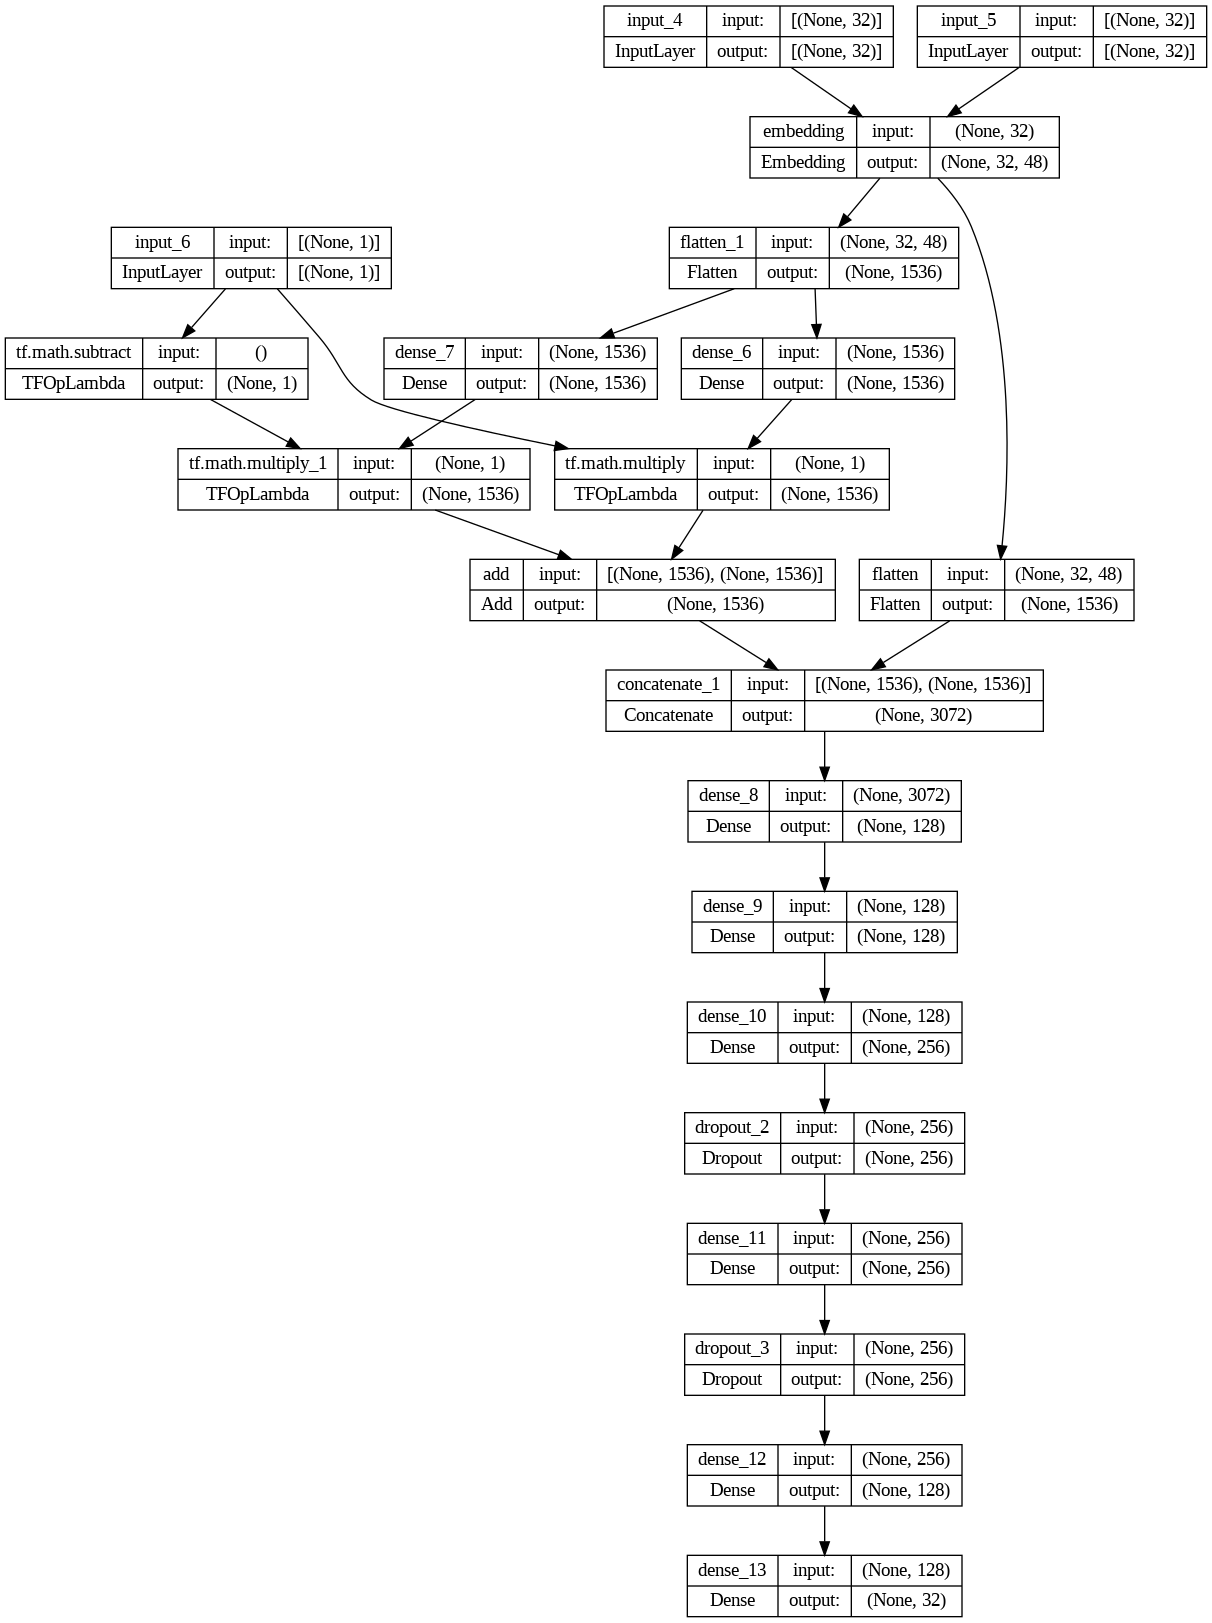

In [ ]:
# tf.keras.utils.plot_model(model, to_file="/tmp/model_1.png", show_shapes=True) # Plot du modele

We save the model and put it in a zip file to download it from colab

In [ ]:
model.save("base_model") # Sauvergade modèle

In [ ]:
import shutil
shutil.make_archive("base_modelFR", 'zip', "base_model") # compression du modele en fichier zip (contrainte google colab pour le télécharger)

'/content/base_modelFR.zip'

Model evaluation

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(((test_input1, test_input2, test_input3), test_outputs))


In [ ]:
model.evaluate(test_dataset.batch(BATCH_SIZE)) # Evaluation

9/9 [==============================] - 0s 4ms/step - loss: 49.5851 - precision_1: 0.9690 - cosine_similarity: 0.9945


[49.58510971069336, 0.969001293182373, 0.9945164322853088]

We plot the training loss per epoch

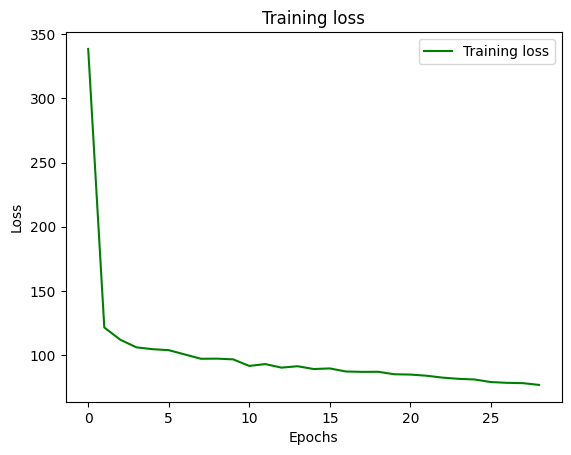

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

All of the code below serves to test the model on individual swipes with a recommendation function and to also measure inference time ...etc

In [ ]:
cars_clone = cars.copy()
cars_clone = cars_clone[cars_clone["id"] != 280]

In [ ]:
config = model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

(None, 32)


In [ ]:

def recommend(previous_car_id, user_session_vec, like, car_vector = None):
  # input = [np.array([np.array(car_vectors[previous_car_id]),np.array(user_session_vec) ,np.array(like)])]
  # print(input)
  #print(input.shape)
  #print(input.shape)
  if car_vector != None:
    input1 = np.array([car_vector])

  input1 = np.array([car_vectors[previous_car_id]])
  input2 = np.array([user_session_vec])
  input3 = np.array([like])
  ideal_car = model.predict([input1, input2, input3])
  #ideal_car = model.predict(input)
  print(ideal_car)
  ideal_car = ideal_car[0]
  def func(row, ideal_car):
      # print(row)
      # print(ideal_car)
      # print("====")
      # print(row["car_vector"])
      # print("Car vector")
      # print(np.nan_to_num(car_vectors[row["id"]]).reshape(1,-1))
      # print("ideal_car")
      # print(np.nan_to_num(np.array(ideal_car).reshape(1,-1)))
      cos_sim = cosine_similarity(np.nan_to_num(car_vectors[row["id"]]).reshape(1,-1), np.nan_to_num(np.array(ideal_car).reshape(1,-1)))
      #print(row["id"], " : ", cos_sim)
      return cos_sim[0][0]
    #return np.linalg.norm(car_vectors[row["id"]]-ideal_car)
  # Convert dict_values to list before passing it to cosine_similarity
  cars_clone["similarity_scores"] = cars_clone.apply((lambda row : func(row,ideal_car)),axis=1)
  #print(cars_clone.head())
  recommended_car = cars_clone.sort_values("similarity_scores",ascending=False).iloc[0].to_dict()
  return ideal_car, recommended_car

In [ ]:
# cars_clone.to_csv("cars_preproc.csv")

In [ ]:
# cars_clone[cars_clone["id"] == 273]

Look for Gray RENAULT car 

In [ ]:
# cars_clone[cars_clone["id"] == 6]

In [ ]:
import timeit

TEST RECOMMENDATIONS

In [ ]:
new_session_vec, recommendation = recommend(6, [0]*32,1)
print(recommendation)
print("id : ",recommendation["id"])

1/1 [==============================] - 0s 113ms/step
[[  0.          4.716051   26.643747   26.700026   16.752068   16.753088
   16.769882   16.660915  101.87468   101.68059     6.758856    0.
    6.6857104   0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.          4.3373423   5.4745355   5.4477253 103.40393
  102.61547     0.       ]]
{'brand': 'NISSAN', 'model': 'Qashqai', 'dealer': 'sofibrie', 'url': 'https://www.leboncoin.fr/voitures/2255242530.htm', 'price': 19.99, 'year': 118, 'km': 4.4873, 'fuel': 'Essence', 'gearbox': 'Manuelle', 'color': 'Gris', 'doors': 5, 'seats': 5.0, 'fiscalPower': 6, 'DINPower': 116, 'critAir': 1.0, 'nb_img': 20, 'link': nan, 'id': 81, 'brand_n': 2, 'model_n': 29, 'fuel_n': 0, 'gearbox_n': 0, 'color_n': 1, 'similarity_scores': 0.9991031274391144}


In [ ]:
new_session_vec, recommendation = recommend(recommendation["id"], list(new_session_vec),1)
print(recommendation)
print("id : ",recommendation["id"])

In [ ]:
new_session_vec, recommendation = recommend(recommendation["id"], list(new_session_vec),1)
print(recommendation)
print("id : ",recommendation["id"])

In [ ]:
new_session_vec, recommendation = recommend(recommendation["id"], list(new_session_vec),1)
print(recommendation)
print("id : ",recommendation["id"])

In [ ]:
def inference_measure():
    model.predict([np.array([car_vectors[8]]), np.array([new_session_vec]), np.array([0])])

In [ ]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 19ms/step


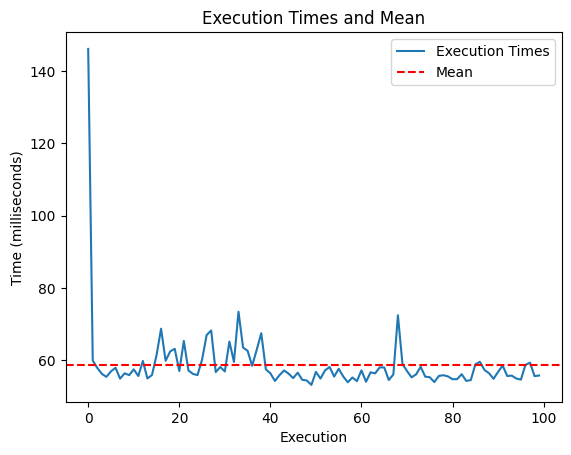

In [ ]:
# Measure execution times in milliseconds
execution_times = [time * 1000 for time in timeit.repeat(inference_measure, repeat=100, number=1)]

# Calculate mean execution time
mean_execution_time = sum(execution_times) / len(execution_times)

# Plotting
plt.plot(execution_times, label='Execution Times')
plt.axhline(y=mean_execution_time, color='r', linestyle='--', label='Mean')
plt.xlabel('Execution')
plt.ylabel('Time (milliseconds)')
plt.title('Execution Times and Mean')
plt.legend()

1/1 [==============================] - 0s 22ms/step
[[ 0.         0.        10.043322  10.084425   6.6186275  6.2436137
   6.706827   6.360453  41.78423   40.811695   2.7820473  2.9048257
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.9734153  1.5408767  2.2345588  0.        45.347843
  44.000294   0.       ]]
1/1 [==============================] - 0s 21ms/step
[[ 0.         0.        10.043322  10.084425   6.6186275  6.2436137
   6.706827   6.360453  41.78423   40.811695   2.7820473  2.9048257
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.9734153  1.5408767  2.2345588  0.        45.347843
  44.000294   0.       ]]
1/1 [==============================] - 0s 18ms/step
[[ 0.         0.        10.043322  10.084425   6.6186275  6.2436137
   6.706827   6.360453  41.78423   40.811695   2.7820473  2.9048257
   0. 

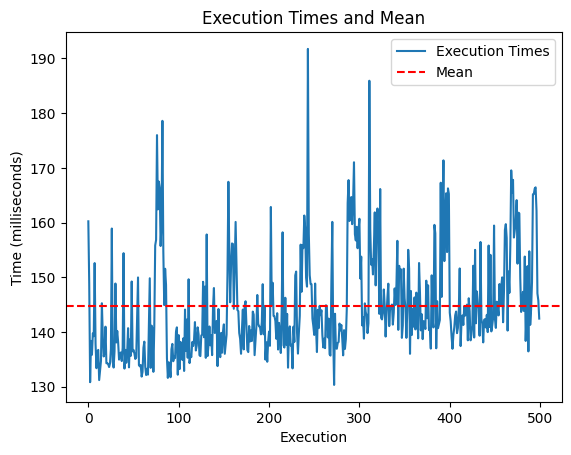

In [ ]:
def inference_cosim():
  recommend(6, new_session_vec,1)

# Measure execution times in milliseconds
execution_times = [time * 1000 for time in timeit.repeat(inference_cosim, repeat=500, number=1)]

# Calculate mean execution time
mean_execution_time = sum(execution_times) / len(execution_times)

# Plotting
plt.plot(execution_times, label='Execution Times')
plt.axhline(y=mean_execution_time, color='r', linestyle='--', label='Mean')
plt.xlabel('Execution')
plt.ylabel('Time (milliseconds)')
plt.title('Execution Times and Mean')
plt.legend()

Testing cosine similarity with and without batching :

In [ ]:
model.predict([np.array([car_vectors[8]]), np.array([new_session_vec]), 0])

ValueError: ignored

In [ ]:
new_session_vec, recommendation = recommend(6, new_session_vec,1)
print(recommendation)

1/1 [==============================] - 0s 81ms/step
[[ 0.         3.6118839 17.313566  17.12662    8.472287   8.645073
   8.442118   8.376105  38.3072    38.101086   2.8449714  2.8878834
   2.765623   0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.7334673  1.9150404  2.6708221  2.411793  47.76479
  47.87113    0.       ]]
{'brand': 'VOLKSWAGEN', 'model': 'Tiguan', 'dealer': 'groupe_gueudet', 'url': 'https://www.leboncoin.fr/voitures/2272265380.htm', 'price': 29.99, 'year': 120, 'km': 7.7969, 'fuel': 'Diesel', 'gearbox': 'Automatique', 'color': 'Gris', 'doors': 5, 'seats': 5.0, 'fiscalPower': 8, 'DINPower': 150, 'critAir': 2.0, 'nb_img': 20, 'link': nan, 'id': 309, 'brand_n': 5, 'model_n': 61, 'fuel_n': 1, 'gearbox_n': 1, 'color_n': 1, 'similarity_scores': 0.998725761884502}


In [ ]:
recommendation

{'brand': 'VOLKSWAGEN',
 'model': 'Tiguan',
 'dealer': 'groupe_gueudet',
 'url': 'https://www.leboncoin.fr/voitures/2272265380.htm',
 'price': 29.99,
 'year': 120,
 'km': 7.7969,
 'fuel': 'Diesel',
 'gearbox': 'Automatique',
 'color': 'Gris',
 'doors': 5,
 'seats': 5.0,
 'fiscalPower': 8,
 'DINPower': 150,
 'critAir': 2.0,
 'nb_img': 20,
 'link': nan,
 'id': 309,
 'brand_n': 5,
 'model_n': 61,
 'fuel_n': 1,
 'gearbox_n': 1,
 'color_n': 1,
 'similarity_scores': 0.998725761884502}

In [ ]:
session_vec2, rec2 = recommend(81,list(new_session_vec), 0)

1/1 [==============================] - 0s 19ms/step
[[ 0.         1.3342093  5.717625   5.5887303  6.6285176  6.707984
   6.5288367  6.5251217 31.590536  31.752195   1.6719328  1.6104918
   1.5918298  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.453186   1.7329006  2.0929637  1.9744596 37.97661
  38.249928   0.       ]]


In [ ]:
session_vec2a, rec2a = recommend(81,list(new_session_vec), 1)

1/1 [==============================] - 0s 19ms/step
[[ 0.         0.6478969  2.691318   2.609465   5.711566   5.8082027
   5.6687117  5.5989785 35.894863  36.01746    1.9371023  1.8592573
   1.802535   0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.6486439  1.9070951  1.9645206  1.8919189 37.525887
  37.707558   0.       ]]


In [ ]:
rec2

{'brand': 'VOLKSWAGEN',
 'model': 'T-Roc',
 'dealer': 'groupe_gueudet',
 'url': 'https://www.leboncoin.fr/voitures/2306520846.htm',
 'price': 25.49,
 'year': 120,
 'km': 7.0902,
 'fuel': 'Essence',
 'gearbox': 'Automatique',
 'color': 'Blanc',
 'doors': 5,
 'seats': 5.0,
 'fiscalPower': 8,
 'DINPower': 150,
 'critAir': 1.0,
 'nb_img': 20,
 'link': nan,
 'id': 287,
 'brand_n': 5,
 'model_n': 28,
 'fuel_n': 0,
 'gearbox_n': 1,
 'color_n': 0,
 'similarity_scores': 0.9991344889158531}

In [ ]:
rec2a

{'brand': 'CITROEN',
 'model': 'C3 Aircross',
 'dealer': 'spoticar_preview',
 'url': 'https://www.leboncoin.fr/voitures/2243435213.htm',
 'price': 17.49,
 'year': 118,
 'km': 3.5433,
 'fuel': 'Diesel',
 'gearbox': 'Automatique',
 'color': 'Blanc',
 'doors': 5,
 'seats': 5.0,
 'fiscalPower': 6,
 'DINPower': 120,
 'critAir': 2.0,
 'nb_img': 20,
 'link': nan,
 'id': 214,
 'brand_n': 0,
 'model_n': 7,
 'fuel_n': 1,
 'gearbox_n': 1,
 'color_n': 0,
 'similarity_scores': 0.9995044809821265}

In [ ]:
session_vec3_2, rec3_2 = recommend(47,list(session_vec2), 1)

1/1 [==============================] - 0s 83ms/step
[[ 0.         1.0310086  5.137087   5.0584884  5.8007965  5.9503055
   5.7741203  5.7078896 37.543148  37.550335   2.49932    2.4391408
   2.3476815  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         1.7025299  1.9502324  2.1361423  2.0414047 40.568066
  40.814728   0.       ]]


In [ ]:
rec3_2

{'brand': 'PEUGEOT',
 'model': '2008',
 'dealer': 'sofibrie',
 'url': 'https://www.leboncoin.fr/voitures/2259732225.htm',
 'price': 22.89,
 'year': 121,
 'km': 6.4655,
 'fuel': 'Essence',
 'gearbox': 'Manuelle',
 'color': 'Gris',
 'doors': 5,
 'seats': 5.0,
 'fiscalPower': 7,
 'DINPower': 131,
 'critAir': 1.0,
 'nb_img': 20,
 'link': nan,
 'id': 41,
 'brand_n': 4,
 'model_n': 9,
 'fuel_n': 0,
 'gearbox_n': 0,
 'color_n': 1,
 'similarity_scores': 0.9984201779964135}

In [ ]:
session_vec3a_2, rec3a_2 = recommend(47,list(session_vec2), 0)

1/1 [==============================] - 0s 19ms/step
[[ 0.          0.58187366  2.4172459   2.4889994   4.8517675   4.881156
   4.8610864   4.901799   34.4161     34.33754     1.4989735   1.314088
   1.4917495   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          1.5831153   1.85137     1.5730143   1.515659   29.27231
  29.57087     0.        ]]


In [ ]:
rec3a_2